In [ ]:
"""
This notebook performs EDA with preprocessing on the relevant data, to prepare for model building.
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import numpy as np
import lightgbm
import pickle

from sklearn import preprocessing
from typing import Union, List
from mrmr import mrmr_classif

In [266]:
def twentyfour_hour_to_float(HHMM: str) -> float:
    """
    Converts a time in HHMM format to a float representing hours.

    Parameters
    ----------
    HHMM : str
        A string representing time in HHMM format (e.g., '1230' for 12:30 PM).

    Returns:
    ----------
    float
        A float representing the time in hours. If HHMM is '-', returns NaN.
    """

    if HHMM == "-":
        return np.nan
    else:
        hour = float(HHMM[:2])
        minute = float(HHMM[2:])
        return hour + minute / 60


def avg_wind_direction(S1: Union[float, np.nan], S2: Union[float, np.nan]) -> float:
    """
    Calculates the average wind direction from two stations, accounting for circular nature of wind direction.

    Parameters
    ----------
    S1 : float or np.nan
        Wind direction from Station 1 (in 10-degree increments, 0-35 scale).
    S2 : float or np.nan
        Wind direction from Station 2 (in 10-degree increments, 0-35 scale).

    Returns
    -------
    float
        Averaged wind direction. Handles missing values and circular differences.
    """

    # Handle missing values
    if S1 == np.nan:
        avg = float(S2)
    elif S2 == np.nan:
        avg = float(S1)

    # Handle circular difference (i.e., crossing the 0/36 boundary)
    elif np.abs(S1 - S2) > 18:
        if S1 < S2:
            S1 += 36
        else:
            S2 += 36
        avg = (S1 + S2) / 2.0
    else:
        avg = (S1 + S2) / 2.0

    # Adjust back if average exceeds 36 (due to circular adjustment)
    if avg >= 36:
        avg -= 36

    return avg


def combine_conditions(S1: str, S2: str) -> Union[str, List[str]]:
    """
    Combines weather condition codes from two stations.

    Parameters
    ----------
    S1 : str
        Condition string from Station 1 (space-separated codes).
    S2 : str
        Condition string from Station 2 (space-separated codes).

    Returns
    -------
    str or list
        Combined unique condition codes. Returns empty string if both are empty.
    """

    # Handle empty conditions from both stations
    if S1 == " " and S2 == " ":
        return ""
    elif S1 == " ":
        return S2
    elif S2 == " ":
        return S1
    else:
        # Split condition codes into lists and combine unique codes
        S1_list = S1.split(" ")
        S2_list = S2.split(" ")
        return list(set(S1_list + S2_list))


def avg_col(S1: Union[float, np.nan], S2: Union[float, np.nan]) -> float:
    """
    Computes the average of two numeric values, handling missing data.

    Parameters
    ----------
    S1 : float or np.nan
        Value from Station 1.
    S2 : float or np.nan
        Value from Station 2.

    Returns
    -------
    float
        Average of S1 and S2, or the non-missing value if one is missing.
    """

    # Handle missing values
    if S1 == np.nan:
        avg = float(S2)
    elif S2 == np.nan:
        avg = float(S1)
    else:
        avg = (S1 + S2) / 2.0

    return avg


def plot_numerical_histograms(df, title_prefix: str = "") -> plt.Figure:
    """
    Plots histograms for all numerical columns in a DataFrame using subplots.

    Parameters
    ----------
    df : pd.DataFrame
        The DataFrame containing the data.
    title_prefix : str, optional
        Prefix for the plot titles.

    Returns
    ----------
    plt.Figure
        The subplots of all numerical columns
    """

    num_cols = df.select_dtypes(include=[np.number]).columns
    n_cols = 3
    n_rows = int(np.ceil(len(num_cols) / n_cols))
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
    axes = axes.flatten()
    for i, col in enumerate(num_cols):
        df[col].hist(ax=axes[i], bins=30)
        axes[i].set_title(f"{title_prefix}{col}")
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()

    return fig


def plot_corr_heatmap(df, title: str = "Correlation Heatmap") -> plt.Figure:
    """
    Plots a seaborn correlation heatmap for the numerical features of a DataFrame.

    Parameters
    ----------
    df : pd.DataFrame
        The DataFrame containing the data.
    title : str, optional
        Title for the heatmap.

    Returns
    -------
    matplotlib.figure.Figure
        The matplotlib figure object.
    """

    num_df = df.select_dtypes(include=[np.number])
    fig, ax = plt.subplots(
        figsize=(min(1.5 * len(num_df.columns), 16), min(1.2 * len(num_df.columns), 12))
    )
    sns.heatmap(num_df.corr(), annot=True, cmap="coolwarm", ax=ax)
    ax.set_title(title)

    plt.tight_layout()

    return fig


def plot_boxplots(df, title_prefix: str = ""):
    """
    Plots boxplots for all numerical columns in a DataFrame using subplots.

    Parameters
    ----------
    df : pd.DataFrame
        The DataFrame containing the data.
    title_prefix : str, optional
        Prefix for the plot titles.
    """

    num_cols = df.select_dtypes(include=[np.number]).columns
    plt.figure(figsize=(15, 6))
    sns.boxplot(data=df[num_cols], orient="h")
    plt.title(f"Boxplot of Numerical Features in {title_prefix} Data")
    plt.show()

In [267]:
weather = pd.read_pickle("../data/weather.pkl")
mosquito = pd.read_pickle("../data/mosquito.pkl")

Here, I print out the info for each dataframe to get some basic insights into the datatype of the 
features, null counts, and other important information to confirm.

In [268]:
print(mosquito.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10506 entries, 0 to 10505
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Date                    10506 non-null  object 
 1   Address                 10506 non-null  object 
 2   Species                 10506 non-null  object 
 3   Block                   10506 non-null  int64  
 4   Street                  10506 non-null  object 
 5   Trap                    10506 non-null  object 
 6   AddressNumberAndStreet  10506 non-null  object 
 7   Latitude                10506 non-null  float64
 8   Longitude               10506 non-null  float64
 9   AddressAccuracy         10506 non-null  int64  
 10  NumMosquitos            10506 non-null  int64  
 11  WnvPresent              10506 non-null  int64  
 12  year                    10506 non-null  int32  
dtypes: float64(2), int32(1), int64(4), object(6)
memory usage: 1.0+ MB
None


In [269]:
print(weather.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2944 entries, 0 to 2943
Data columns (total 22 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Station      2944 non-null   int64  
 1   Date         2944 non-null   object 
 2   Tmax         2944 non-null   int64  
 3   Tmin         2944 non-null   int64  
 4   Tavg         2944 non-null   object 
 5   Depart       2944 non-null   object 
 6   DewPoint     2944 non-null   int64  
 7   WetBulb      2944 non-null   object 
 8   Heat         2944 non-null   object 
 9   Cool         2944 non-null   object 
 10  Sunrise      2944 non-null   object 
 11  Sunset       2944 non-null   object 
 12  CodeSum      2944 non-null   object 
 13  Depth        2944 non-null   object 
 14  Water1       2944 non-null   object 
 15  SnowFall     2944 non-null   object 
 16  PrecipTotal  2944 non-null   object 
 17  StnPressure  2944 non-null   object 
 18  SeaLevel     2944 non-null   object 
 19  Result

In [270]:
# Convert dates in each file to datetime objects
for df in [weather, mosquito]:
    df.Date = pd.to_datetime(df.Date, format="%Y-%m-%d")

In [271]:
# In a similar way, many other variables in the weather dataframe are objects due to the values that
# some observations have, such as "M" for missing values. These will be converted to numeric.
num_vars = [
    "Tavg",
    "Depart",
    "DewPoint",
    "WetBulb",
    "Heat",
    "Cool",
    "PrecipTotal",
    "StnPressure",
    "SeaLevel",
    "ResultSpeed",
    "ResultDir",
    "AvgSpeed",
]
for var in num_vars:
    weather[var] = pd.to_numeric(weather[var], errors="coerce")

Now, I start focusing on preprocessing for the weather data.

In [272]:
# Extracting the 24 hour
weather.Sunrise = weather.Sunrise.apply(twentyfour_hour_to_float)
weather.Sunset = weather.Sunset.apply(twentyfour_hour_to_float)

# Creating new feature: hours in day
weather["hours_in_day"] = weather.Sunset - weather.Sunrise

In [273]:
# Show the # of times M appears in each column, which means missing value for this data set
for col in weather.columns:
    count = weather[col].astype(str).str.count("M").sum()
    print(f"{col}: {count}")

Station: 0
Date: 0
Tmax: 0
Tmin: 0
Tavg: 0
Depart: 0
DewPoint: 0
WetBulb: 0
Heat: 0
Cool: 0
Sunrise: 0
Sunset: 0
CodeSum: 3
Depth: 1472
Water1: 2944
SnowFall: 1472
PrecipTotal: 0
StnPressure: 0
SeaLevel: 0
ResultSpeed: 0
ResultDir: 0
AvgSpeed: 0
hours_in_day: 0


In [274]:
# Dropping unnecessary columns since a huge chunk is missing
weather.drop(["Depth", "Water1", "SnowFall"], axis=1, inplace=True)

Having separate data sets for both weather stations is not ideal. So, I combine them.

In [275]:
# For simplicity, the data from both weather stations will be combined

# Initialize dataframe to hold combined weather data
combined_weather = pd.DataFrame()

# Split the weather data into two stations
s1 = weather[weather.Station == 1]
s2 = weather[weather.Station == 2]

# Set columns that only have data for Station 1 or the data being the same.
for col in ["Date", "Depart", "Sunrise", "Sunset", "hours_in_day"]:
    combined_weather[col] = s1[col].values

# Apply average functions to the columns that have data for both stations
for col in [
    "Tmax",
    "Tmin",
    "Tavg",
    "DewPoint",
    "WetBulb",
    "Heat",
    "Cool",
    "StnPressure",
    "SeaLevel",
    "ResultSpeed",
    "AvgSpeed",
]:
    combined_weather[col] = [
        avg_col(a, b) for a, b in zip(s1[col].values, s2[col].values)
    ]

# Applying related weather average functions
combined_weather["ResultDir"] = [
    avg_wind_direction(a, b) for a, b in zip(s1.ResultDir.values, s2.ResultDir.values)
]
combined_weather["CodeSum"] = [
    combine_conditions(a, b) for a, b in zip(s1.CodeSum.values, s2.CodeSum.values)
]

# PrecipTotal for each station is too different, so I keep both separate.
combined_weather["PrecipTotal_station1"] = weather.PrecipTotal[
    weather.Station == 1
].values
combined_weather["PrecipTotal_station2"] = weather.PrecipTotal[
    weather.Station == 2
].values

In [276]:
# Check for missing values
for col in combined_weather.columns:
    print(f"{col}: {combined_weather[col].isna().sum()}")

Date: 0
Depart: 0
Sunrise: 0
Sunset: 0
hours_in_day: 0
Tmax: 0
Tmin: 0
Tavg: 11
DewPoint: 0
WetBulb: 4
Heat: 11
Cool: 11
StnPressure: 3
SeaLevel: 9
ResultSpeed: 0
AvgSpeed: 3
ResultDir: 0
CodeSum: 0
PrecipTotal_station1: 163
PrecipTotal_station2: 157


In [277]:
# The precipitation totals have too many missing values to be worth imputing in an accurate
# sense. They will be dropped here.
combined_weather.drop(
    ["PrecipTotal_station1", "PrecipTotal_station2"], axis=1, inplace=True
)

Now, I define more columns for the mosquito trap data based on the date.

In [278]:
# Extract day of year, month, day of week, and year from date column
mosquito["day_of_year"] = mosquito.Date.dt.dayofyear
mosquito["month"] = mosquito.Date.dt.month
mosquito["day_of week"] = mosquito.Date.dt.dayofweek
mosquito["year"] = mosquito.Date.dt.year

At this point, I'm ready to split my data. But before I split my data, I want to do a quick check 
both in the weather and mosquito data for the following:
1. Non-normality in numerical columns
2. Highly correlated features
3. extreme outliers
4. class imbalance in `WnvPresent`

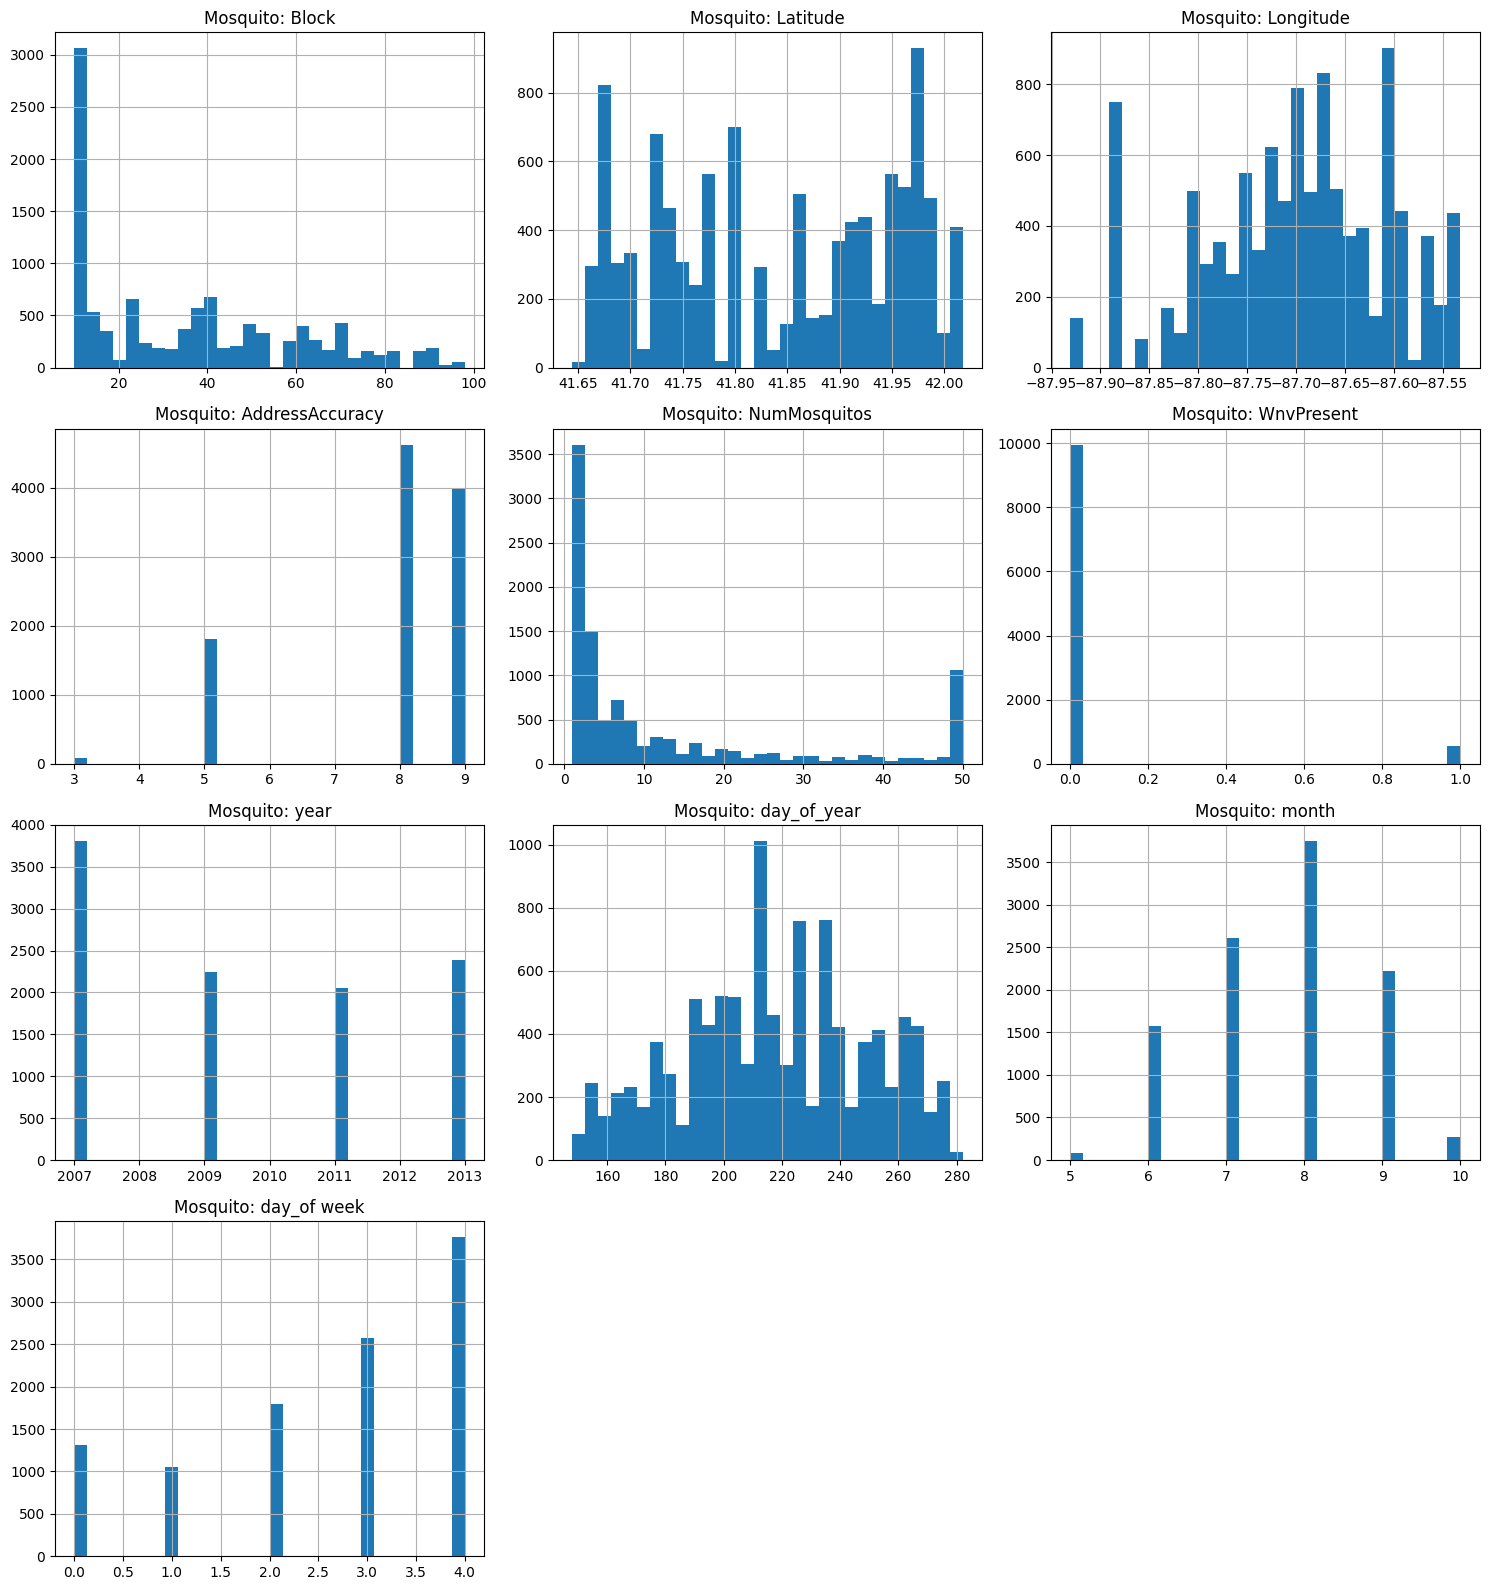

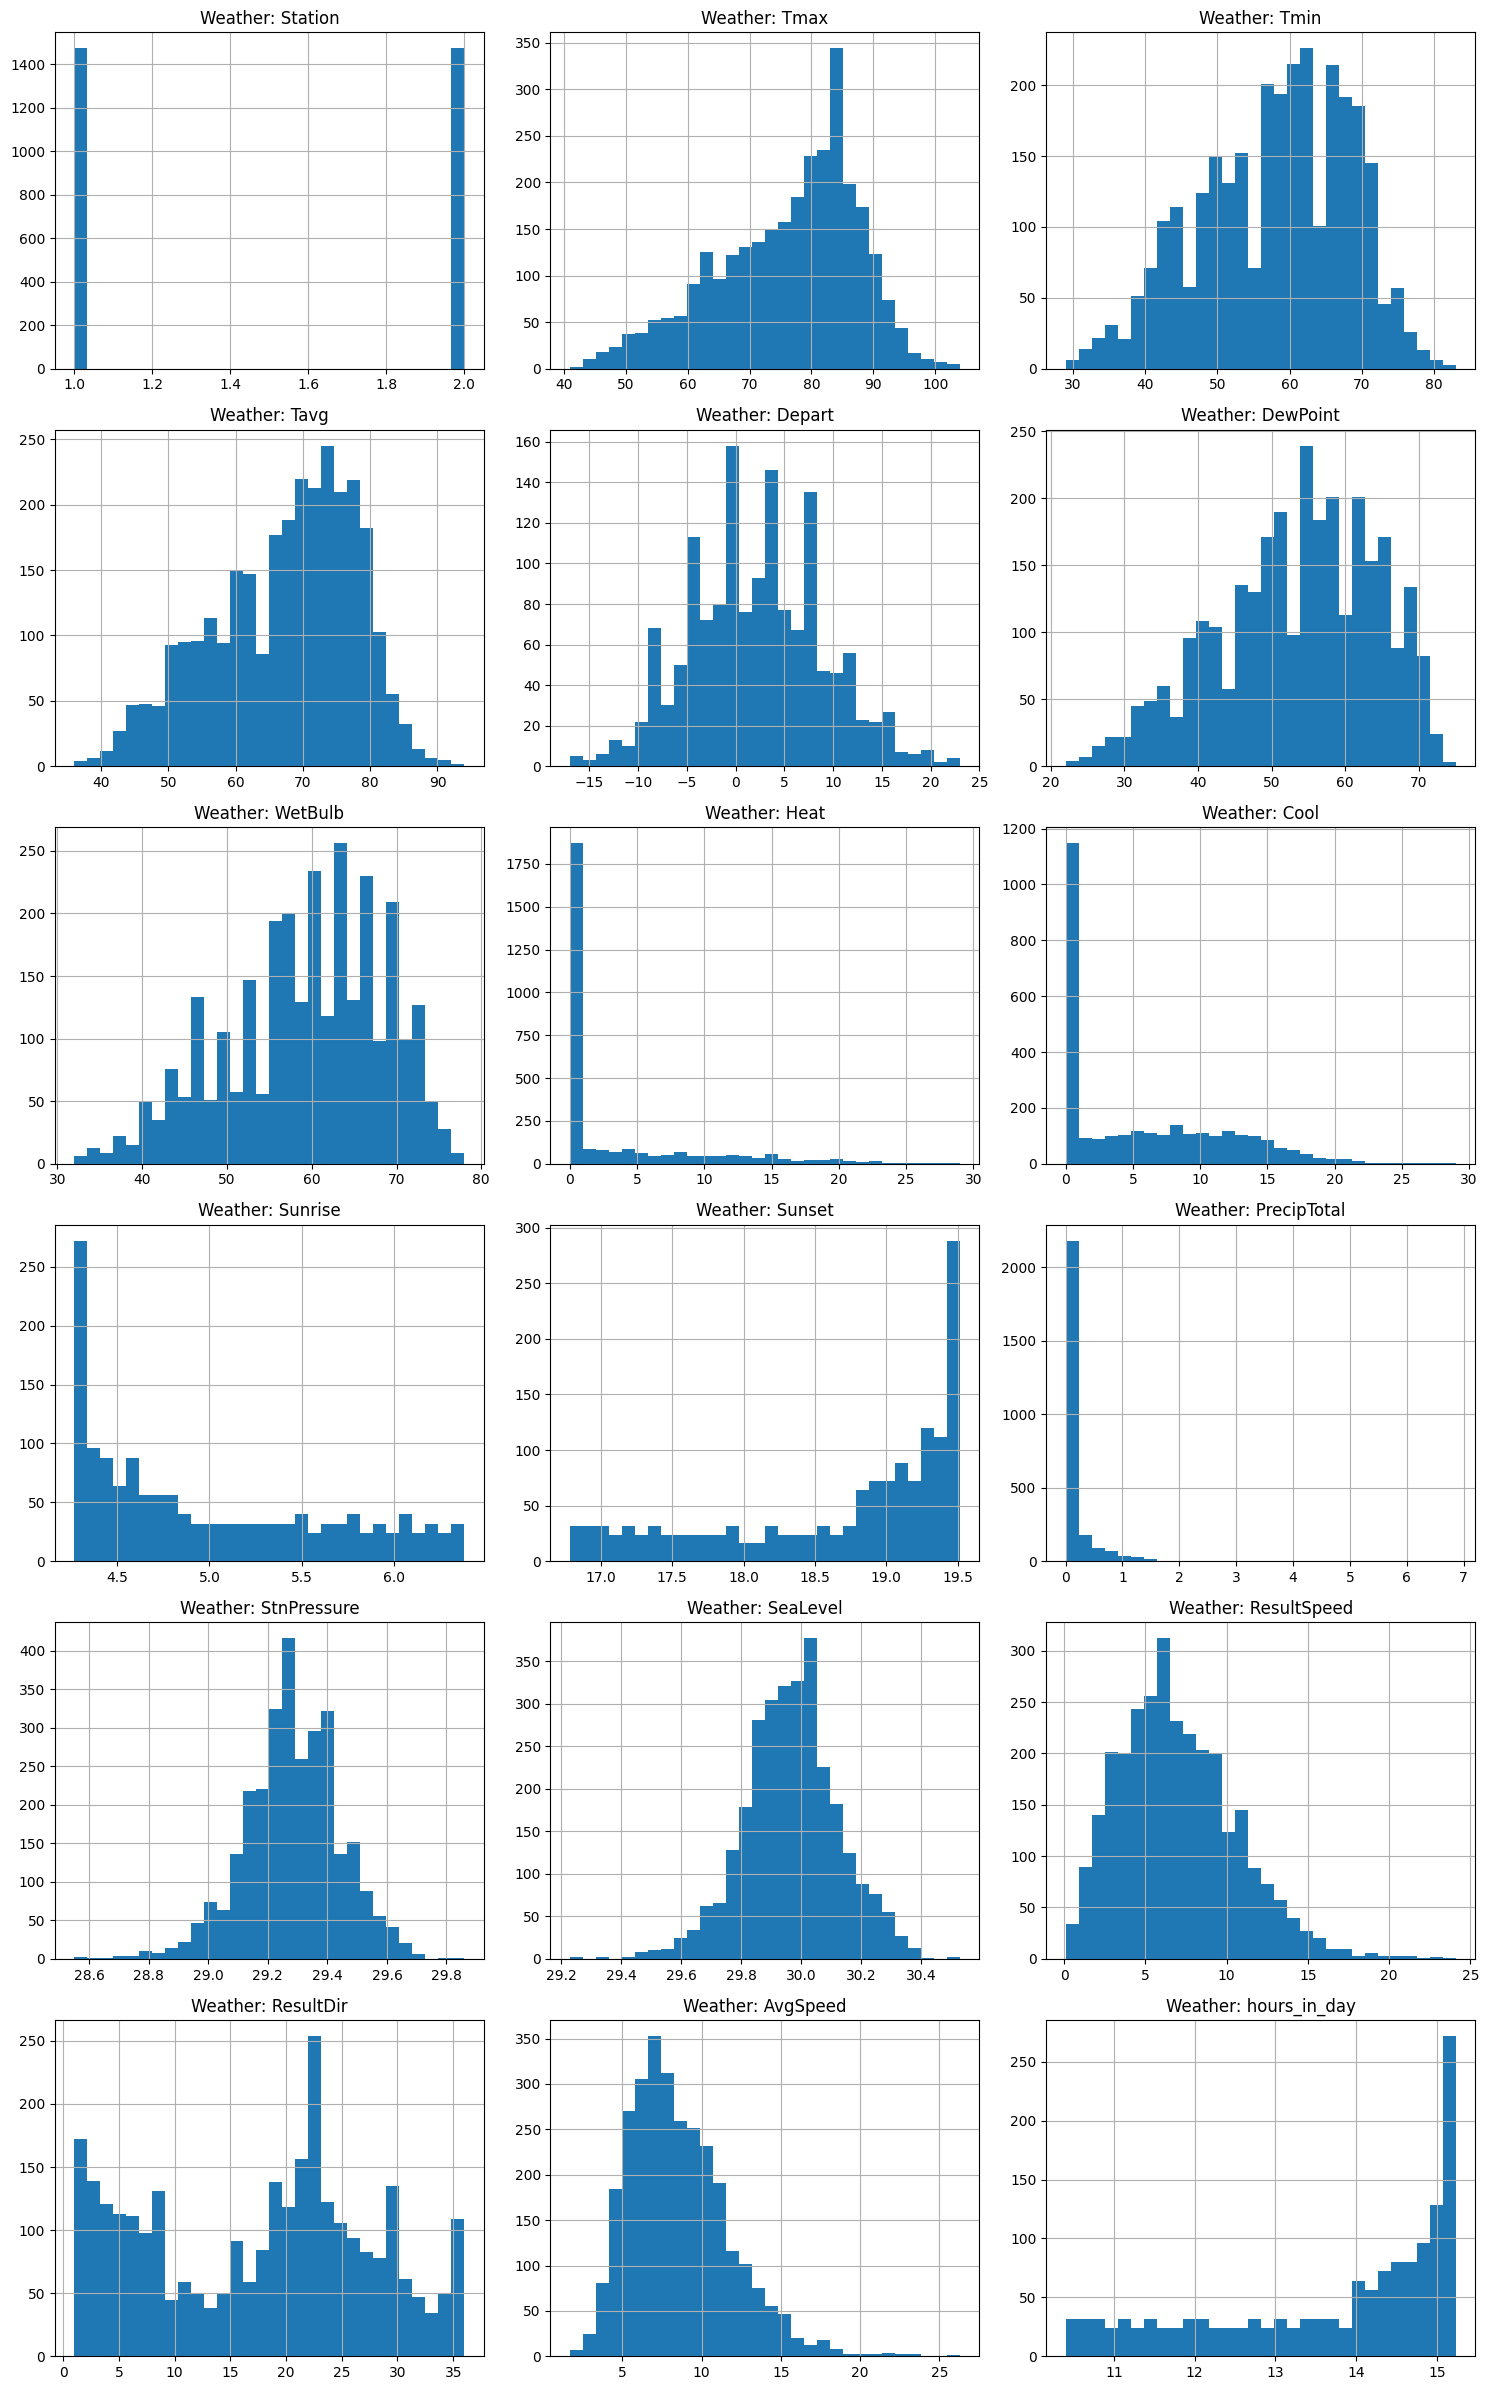

In [279]:
# Plot histograms for mosquito data
mosquito_figure = plot_numerical_histograms(mosquito, title_prefix="Mosquito: ")

# Plot histograms for weather data
weather_figure = plot_numerical_histograms(weather, title_prefix="Weather: ")

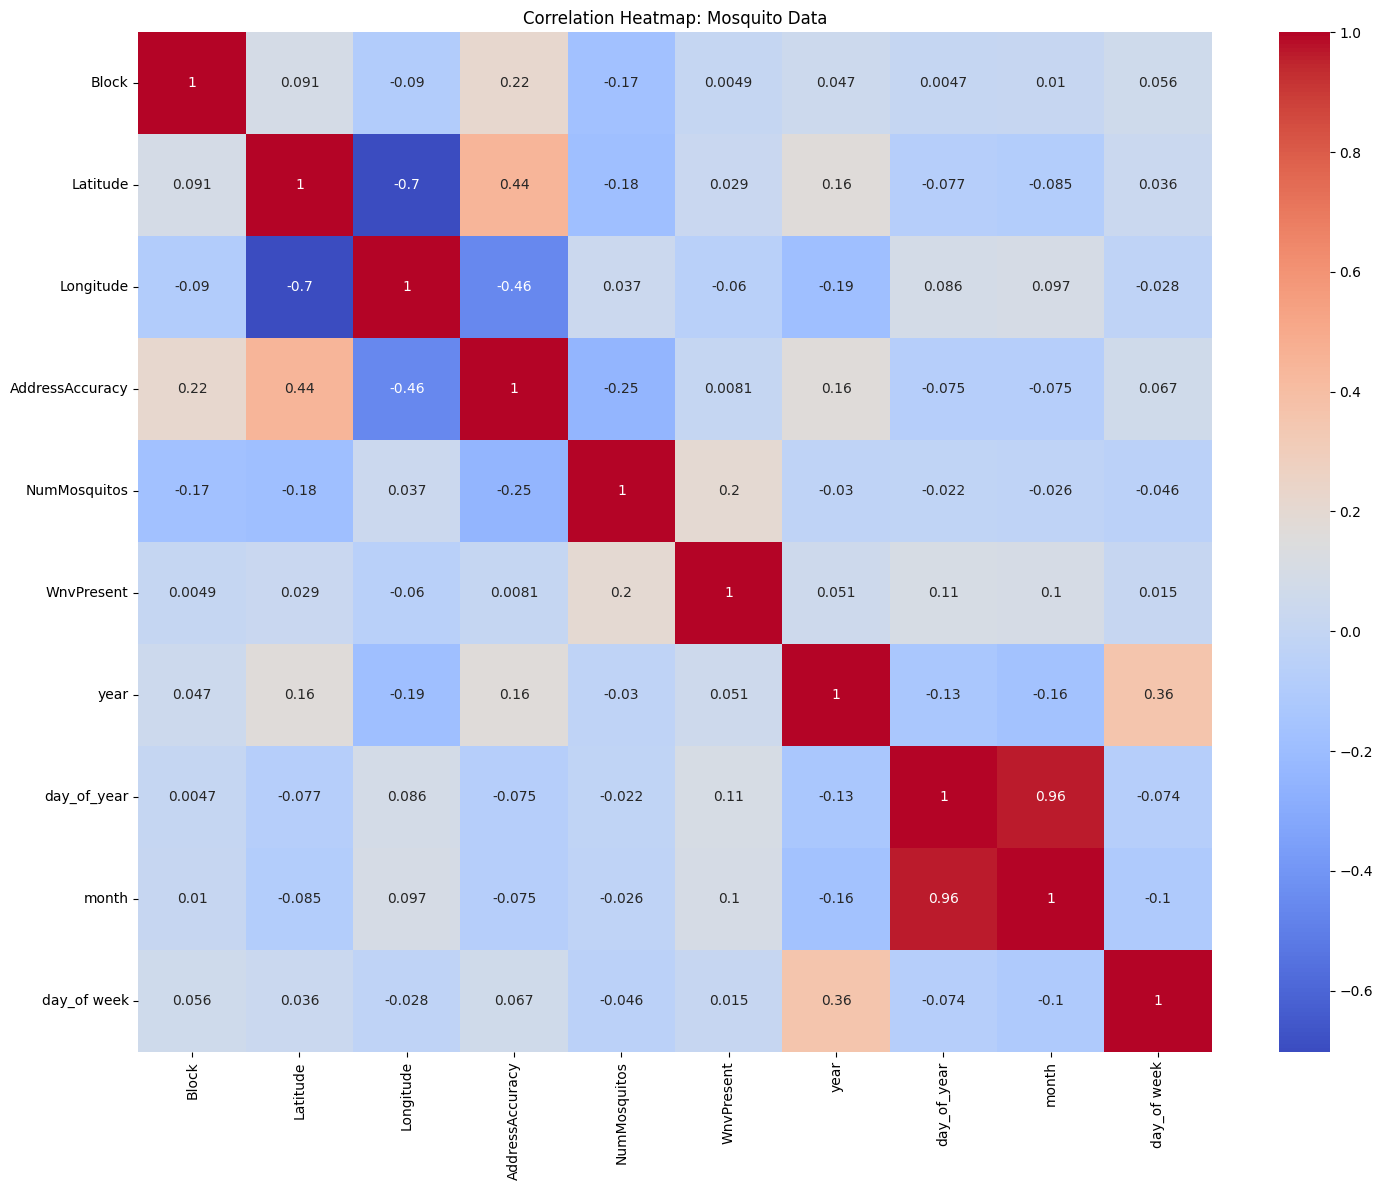

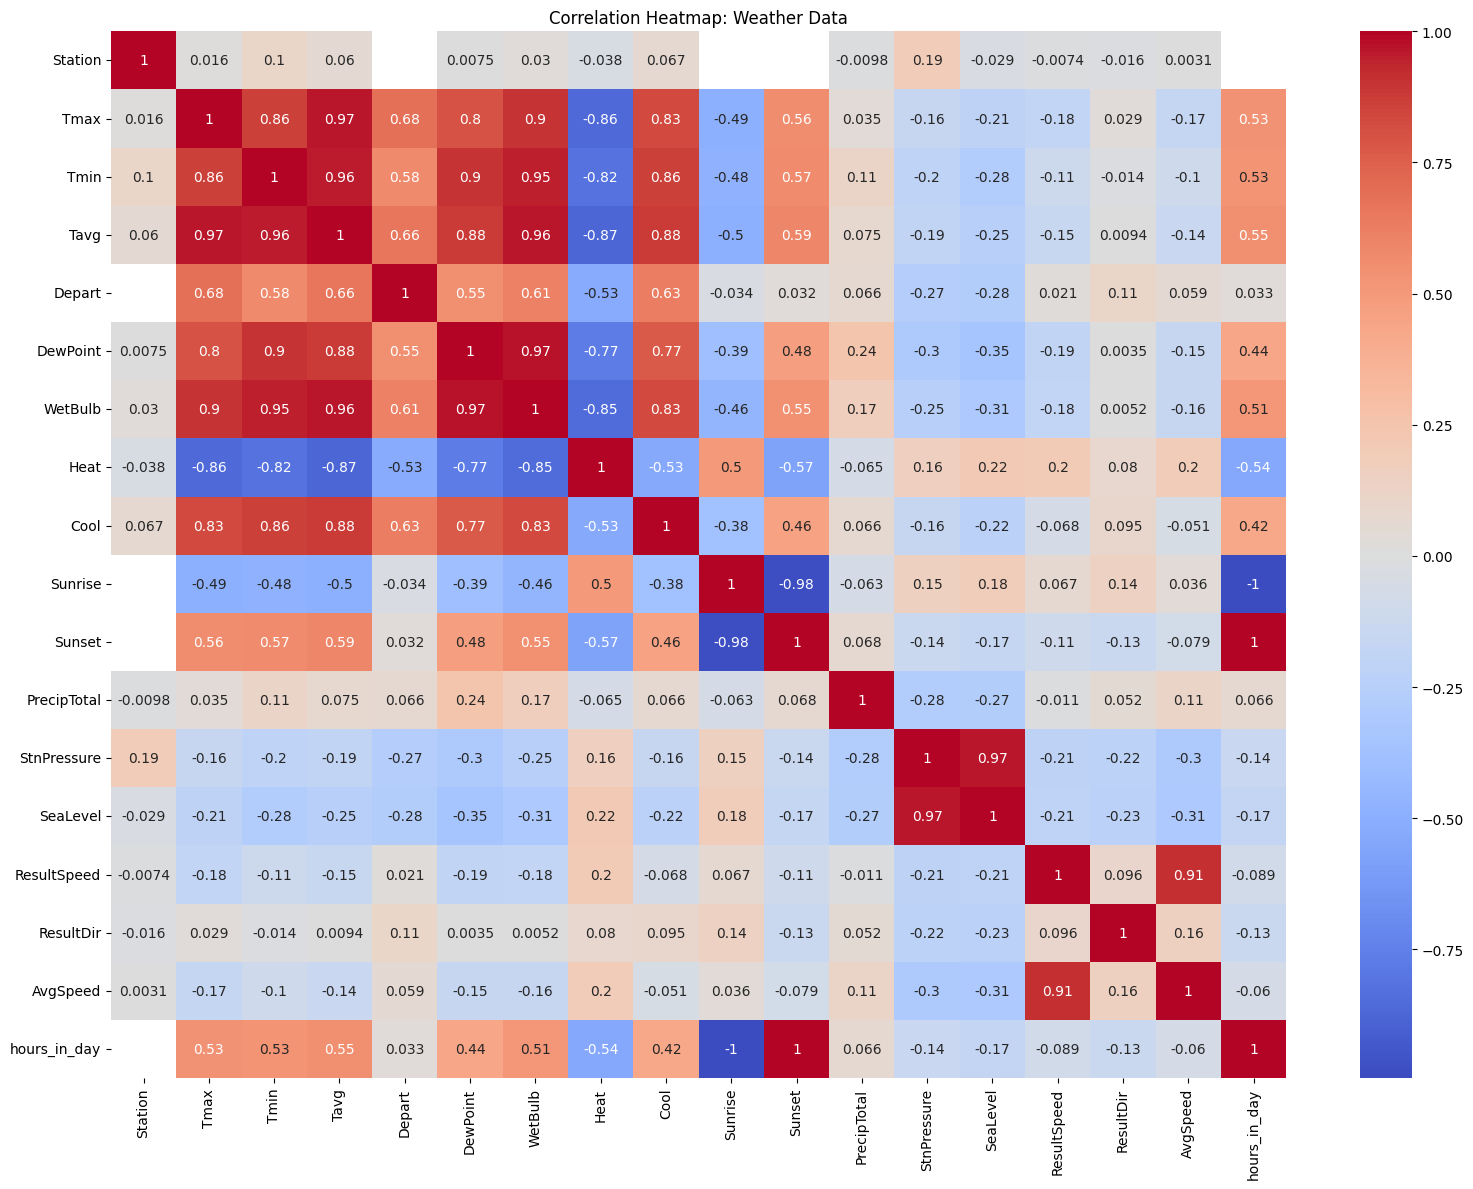

In [280]:
# Show correlation heatmap for mosquito data
mosquito_corr = plot_corr_heatmap(mosquito, title="Correlation Heatmap: Mosquito Data")

# Show correlation heatmap for weather data
weather_corr = plot_corr_heatmap(weather, title="Correlation Heatmap: Weather Data")

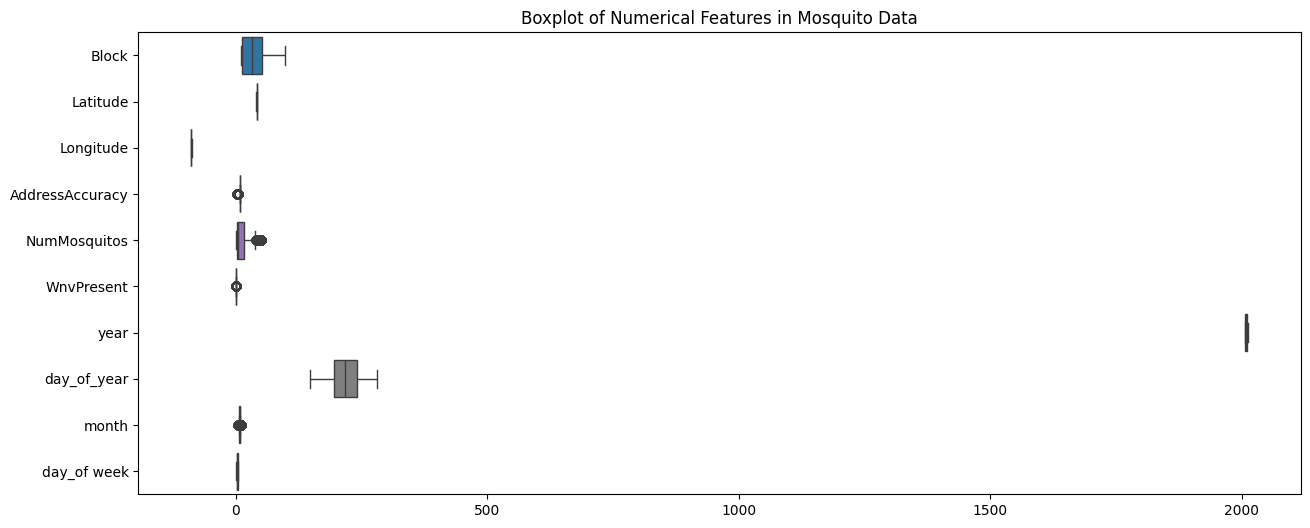

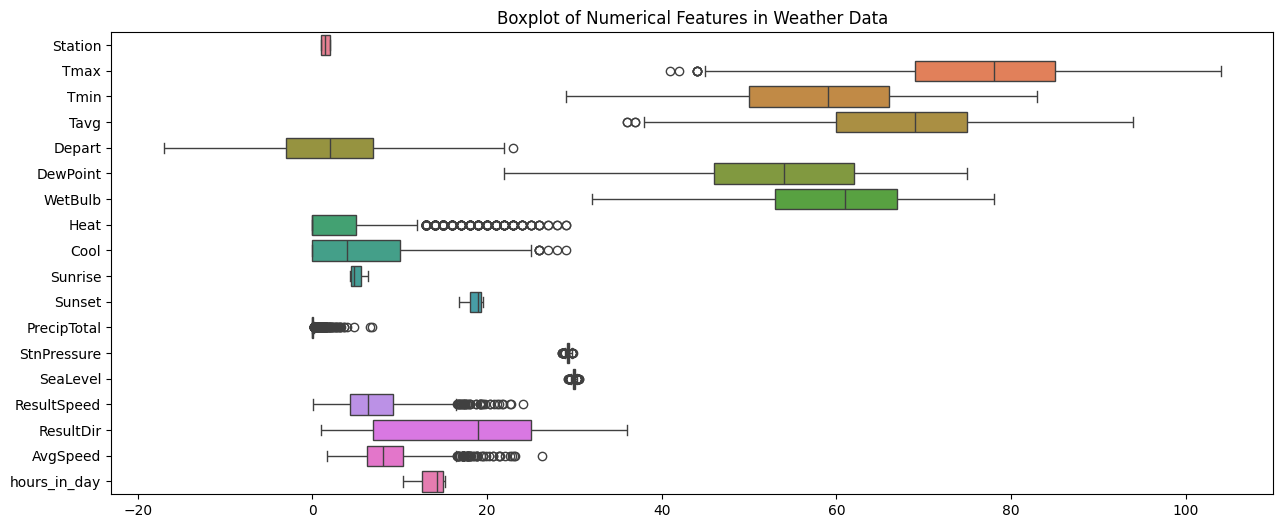

In [281]:
mosquito_boxplot_figure = plot_boxplots(mosquito, title_prefix="Mosquito")
weather_boxplot_figure = plot_boxplots(weather, title_prefix="Weather")

In [282]:
mosquito["WnvPresent"].value_counts()

WnvPresent
0    9955
1     551
Name: count, dtype: int64

From the visualizations, the determined is found:
- Some features are normally distributed in both data frames thus far, but some are skewed.
- The mosquito data has correlated variables between lat/long and month/day of year, which is not 
  abnormal. However, the weather data has more pairs of correlated variables. This is a sign to 
  perform some kind of feature selection to filter these out.
- There are some outliers, but there is nothing extremely abnormal. 
- There is also  class imbalance (which is expected, given I would not expect a large chunk of 
  mosquitos to test positive for WNV).

However, I plan to train a LightGBM model which is tree-based and naturally can handle these issues, 
so I will not worry about preprocessing to fix these issues. However, for other models, I would 
recommmend doing a log transform to ensure all numerical features are normally distributed, 
filtering out outliers using a simple method like IQR/using a more robust algorithm
for outlier detection., and using techniques like downsampling can be done to deal with class 
imbalance.

Feature selection will be performed later.

Anyways, I will continue with splitting my data now, since there are some preprocessing steps and
feature engineering I want to do that may incur data leakage otherwise.

In [283]:
# Since the mosquito data is time based, it would be bad to split randomly, since this can cause
# data leakage. Instead, I will split the data into train, validation, and test sets based on time.
# Train data covers 2007/2009, validation data covers 2011, and test data covers 2013.
train = mosquito[mosquito["Date"].dt.year.isin([2007, 2009])]
valid = mosquito[mosquito["Date"].dt.year == 2011]
test = mosquito[mosquito["Date"].dt.year == 2013]

In [284]:
# Address, Street, and AddressNumberAndStreet provide the same information, so they are removed to
# avoid redundancy.
train = train.drop(["Address", "Street", "AddressNumberAndStreet"], axis=1)
valid = valid.drop(["Address", "Street", "AddressNumberAndStreet"], axis=1)
test = test.drop(["Address", "Street", "AddressNumberAndStreet"], axis=1)

In [285]:
# Check for missing values
for col in train.columns:
    print(f"{col}: {train[col].isna().sum()}")

Date: 0
Species: 0
Block: 0
Trap: 0
Latitude: 0
Longitude: 0
AddressAccuracy: 0
NumMosquitos: 0
WnvPresent: 0
year: 0
day_of_year: 0
month: 0
day_of week: 0


Now I engineer some features.

In [286]:
# Here, I create some new features based on trap data. The idea is to create features that capture
# the distribution of mosquitos and WNV presence across different traps. This can help the model
# understand the relative importance of different traps in terms of mosquito counts and WNV
# presence.
num_by_trap = train[["Trap", "NumMosquitos", "WnvPresent"]].groupby("Trap").agg("sum")
num_by_trap["trap_percent_of_all_mosquitos"] = num_by_trap["NumMosquitos"] / sum(
    num_by_trap.NumMosquitos
)
num_by_trap["trap_percent_with_wnv"] = num_by_trap.WnvPresent / num_by_trap.NumMosquitos
num_by_trap.reset_index(inplace=True)

# Define dictionaries to map trap names to their respective weights
map_mosq_weight = {
    t: v
    for t, v in zip(
        num_by_trap.Trap.values, num_by_trap["trap_percent_of_all_mosquitos"].values
    )
}
map_wnv_weight = {
    t: v
    for t, v in zip(
        num_by_trap.Trap.values, num_by_trap["trap_percent_with_wnv"].values
    )
}

# Create a second mapping for WNV presence, which is the average per-record WNV presence per trap
map_wnv_weight2 = {}
for trap in set(train.Trap):
    map_wnv_weight2[trap] = sum(
        train.WnvPresent[train.Trap == trap] / sum(train.Trap == trap)
    )
map_wnv_weight2

# Map the trap weights to the train, valid, and test sets
train["trap_percent_of_all_mosquitos"] = train.Trap.map(map_mosq_weight)
train["trap_percent_with_wnv"] = train.Trap.map(map_wnv_weight)
train["trap_percent_with_wnv2"] = train.Trap.map(map_wnv_weight2)

valid["trap_percent_of_all_mosquitos"] = valid.Trap.map(map_mosq_weight).fillna(0)
valid["trap_percent_with_wnv"] = valid.Trap.map(map_wnv_weight).fillna(0)
valid["trap_percent_with_wnv2"] = valid.Trap.map(map_wnv_weight2).fillna(0)

test["trap_percent_of_all_mosquitos"] = test.Trap.map(map_mosq_weight).fillna(0)
test["trap_percent_with_wnv"] = test.Trap.map(map_wnv_weight).fillna(0)
test["trap_percent_with_wnv2"] = test.Trap.map(map_wnv_weight2).fillna(0)

I now merge the mosquito data with the weather data after all the preprocessing.

In [287]:
# Join the mosquito data with the combined weather data, left joining on the date column
train_w = pd.merge(train, combined_weather, how="left", on="Date")
valid_w = pd.merge(valid, combined_weather, how="left", on="Date")
test_w = pd.merge(test, combined_weather, how="left", on="Date")

The datatype for the non-numerical columns (outside of datetime) is of type object. However, for
LightGBM models, it is better to encode them as `category`.

In [288]:
for df in [train_w, valid_w, test_w]:
    obj_cols = df.select_dtypes(include="object").columns
    for col in obj_cols:
        # Only convert to category if all non-null values are not lists
        if not df[col].dropna().apply(lambda x: isinstance(x, list)).any():
            df[col] = df[col].astype("category")

I print the info for each subset just as a sanity check to ensure there are no more missing values,
and the datatypes are correct.

In [289]:
print(train_w.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6060 entries, 0 to 6059
Data columns (total 33 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   Date                           6060 non-null   datetime64[ns]
 1   Species                        6060 non-null   category      
 2   Block                          6060 non-null   int64         
 3   Trap                           6060 non-null   category      
 4   Latitude                       6060 non-null   float64       
 5   Longitude                      6060 non-null   float64       
 6   AddressAccuracy                6060 non-null   int64         
 7   NumMosquitos                   6060 non-null   int64         
 8   WnvPresent                     6060 non-null   int64         
 9   year                           6060 non-null   int32         
 10  day_of_year                    6060 non-null   int32         
 11  month            

In [290]:
print(valid_w.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2054 entries, 0 to 2053
Data columns (total 33 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   Date                           2054 non-null   datetime64[ns]
 1   Species                        2054 non-null   category      
 2   Block                          2054 non-null   int64         
 3   Trap                           2054 non-null   category      
 4   Latitude                       2054 non-null   float64       
 5   Longitude                      2054 non-null   float64       
 6   AddressAccuracy                2054 non-null   int64         
 7   NumMosquitos                   2054 non-null   int64         
 8   WnvPresent                     2054 non-null   int64         
 9   year                           2054 non-null   int32         
 10  day_of_year                    2054 non-null   int32         
 11  month            

In [291]:
print(test_w.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2392 entries, 0 to 2391
Data columns (total 33 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   Date                           2392 non-null   datetime64[ns]
 1   Species                        2392 non-null   category      
 2   Block                          2392 non-null   int64         
 3   Trap                           2392 non-null   category      
 4   Latitude                       2392 non-null   float64       
 5   Longitude                      2392 non-null   float64       
 6   AddressAccuracy                2392 non-null   int64         
 7   NumMosquitos                   2392 non-null   int64         
 8   WnvPresent                     2392 non-null   int64         
 9   year                           2392 non-null   int32         
 10  day_of_year                    2392 non-null   int32         
 11  month            

The categorical columns could be encoded, but LightGBM's do not need to do that. However, other 
models may require that step.

However, `CodeSum` contains lists, so I want to apply a multilabel binarizer.

In [292]:
# MultiLabelBinarizer on Codesum
mlb = preprocessing.MultiLabelBinarizer()
mlb_mat = mlb.fit_transform(train_w.CodeSum)
mlb_df = pd.DataFrame(mlb_mat, columns=mlb.classes_)
train_w = pd.concat([train_w, mlb_df], axis=1)

# Repeat on valid/test sets
mlb_mat = mlb.fit_transform(valid_w.CodeSum)
mlb_df = pd.DataFrame(mlb_mat, columns=mlb.classes_)
valid_w = pd.concat([valid_w, mlb_df], axis=1)

mlb_mat = mlb.fit_transform(test_w.CodeSum)
mlb_df = pd.DataFrame(mlb_mat, columns=mlb.classes_)
test_w = pd.concat([test_w, mlb_df], axis=1)

My last preprocessing step is removing any more rows with a few missing values. There aren't that 
many so I didn't find it worthwhile to impute.

In [293]:
for df in [train_w, valid_w, test_w]:
    df.dropna(inplace=True)

Finally, I want to perform feature selection based on the training data.
I remove some columns first that are not useful at 
all (or they are not features), and then I perform feature selection on the remaining columns.
I chose to use mrmr_selection, an estimation of MRMR (normally, this uses mutual information, but
this can be expensive to calculate).

In [296]:
X = train_w.drop("Date Trap Species CodeSum NumMosquitos WnvPresent".split(" "), axis=1)
y = train_w.WnvPresent

# Find the top 15 features
selected_features = mrmr_classif(X=X, y=y, K=15)
print(selected_features)

100%|██████████| 15/15 [00:00<00:00, 28.44it/s]

['year', 'AvgSpeed', 'trap_percent_with_wnv2', 'BR', 'TS', 'trap_percent_with_wnv', 'DewPoint', 'WetBulb', 'Sunrise', 'Tmin', 'TSRA', 'ResultSpeed', 'Cool', 'day_of_year', 'Tavg']


In [ ]:
# Store the final data sets for modeling
for name, df in zip(["train", "valid", "test"], [train_w, test_w, valid_w]):
    df[selected_features].to_pickle(f"../data/{name}_selected.pkl")